<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/custom_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Parser - Simple

## Installing IceVision and IceData
If on Colab run the following cell, else check the [installation instructions](https://airctic.com/dev/install/)

Install from pypi...

In [ ]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11

... or from icevision master

In [ ]:
# # Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
# !wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# # Choose your installation target: cuda11 or cuda10 or cpu
# !bash icevision_install.sh cuda11 master

In [2]:
# Restart kernel after installation
import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'restart': True, 'status': 'ok'}

## Imports
As always, let's import everything from `icevision`. Additionally, we will also need `pandas` (you might need to install it with `pip install pandas`).

In [2]:
from icevision.all import *
import pandas as pd

## Download dataset

We're going to be using a small sample of the chess dataset, the full dataset is offered by roboflow [here](https://public.roboflow.com/object-detection/chess-full)

In [ ]:
data_url = "https://github.com/airctic/chess_sample/archive/master.zip"
data_dir = icedata.load_data(data_url, "chess_sample") / "chess_sample-master"

## Understand the data format

In this task we were given a `.csv` file with annotations, let's take a look at that.

!!! danger "Important"  
    Replace `source` with your own path for the dataset directory.

In [4]:
df = pd.read_csv(data_dir / "annotations.csv")
df.head()

filename  width  height         label  xmin  ymin  xmax  ymax
0    0.jpg    416     416  black-bishop   280   227   310   284
1    0.jpg    416     416    black-king   311   110   345   195
2    0.jpg    416     416   black-queen   237    85   262   159
3    0.jpg    416     416    black-rook   331   277   366   333
4    0.jpg    416     416    black-rook   235     3   255    51

At first glance, we can make the following assumptions:  

  * Multiple rows with the **same** filename, width, height  
  * A **label** for each row
  * A **bbox** [xmin, ymin, xmax, ymax] for each row  
  
Once we know what our data provides we can create our custom `Parser`.  

## Create the Parser

The first step is to create a template record for our specific type of dataset, in this case we're doing standard object detection:

In [5]:
template_record = ObjectDetectionRecord()

Now use the method `generate_template` that will print out all the necessary steps we have to implement.

In [6]:
Parser.generate_template(template_record)

class MyParser(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
    def __iter__(self) -> Any:
    def __len__(self) -> int:
    def record_id(self, o: Any) -> Hashable:
    def parse_fields(self, o: Any, record: BaseRecord, is_new: bool):
        record.set_filepath(<Union[str, Path]>)
        record.set_img_size(<ImgSize>)
        record.detection.set_class_map(<ClassMap>)
        record.detection.add_labels(<Sequence[Hashable]>)
        record.detection.add_bboxes(<Sequence[BBox]>)


We can copy the template and use it as our starting point. Let's go over each of the methods we have to define:

- `__init__`: What happens here is completely up to you, normally we have to pass some reference to our data, `data_dir` in our case.

- `__iter__`: This tells our parser how to iterate over our data, each item returned here will be passed to `parse_fields` as `o`. In our case we call `df.itertuples` to iterate over all `df` rows.

- `__len__`: How many items will be iterating over.

- `imageid`: Should return a `Hashable` (`int`, `str`, etc). In our case we want all the dataset items that have the same `filename` to be unified in the same record.

- `parse_fields`: Here is where the attributes of the record are collected, the template will suggest what methods we need to call on the record and what parameters it expects. The parameter `o` it receives is the item returned by `__iter__`.

!!! danger "Important"  
    Be sure to pass the correct type on all record methods!

In [7]:
class ChessParser(Parser):
    def __init__(self, template_record, data_dir):
        super().__init__(template_record=template_record)

        self.data_dir = data_dir
        self.df = pd.read_csv(data_dir / "annotations.csv")
        self.class_map = ClassMap(list(self.df["label"].unique()))

    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o

    def __len__(self) -> int:
        return len(self.df)

    def record_id(self, o) -> Hashable:
        return o.filename

    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(self.data_dir / "images" / o.filename)
            record.set_img_size(ImgSize(width=o.width, height=o.height))
            record.detection.set_class_map(self.class_map)

        record.detection.add_bboxes([BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)])
        record.detection.add_labels([o.label])

Let's randomly split the data and parser with `Parser.parse`:

In [8]:
parser = ChessParser(template_record, data_dir)

In [9]:
train_records, valid_records = parser.parse()

  0%|          | 0/109 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/7 [00:00<?, ?it/s]

Let's take a look at one record:

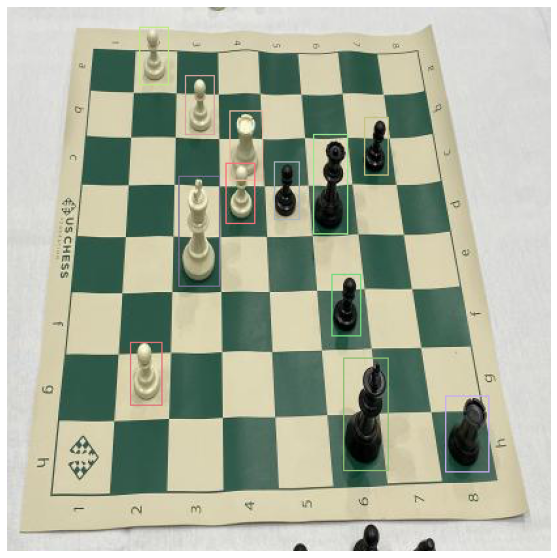

In [10]:
show_record(train_records[0], display_label=False, figsize=(14, 10))

In [11]:
train_records[0]

BaseRecord

common: 
	- Filepath: /root/.icevision/data/chess_sample/chess_sample-master/images/6.jpg
	- Img: None
	- Image size ImgSize(width=416, height=416)
	- Record ID: 6.jpg
detection: 
	- Class Map: <ClassMap: {'background': 0, 'black-bishop': 1, 'black-king': 2, 'black-queen': 3, 'black-rook': 4, 'black-pawn': 5, 'black-knight': 6, 'white-queen': 7, 'white-rook': 8, 'white-king': 9, 'white-bishop': 10, 'white-knight': 11, 'white-pawn': 12}>
	- Labels: [8, 9, 12, 12, 12, 12, 2, 4, 3, 5, 5, 5]
	- BBoxes: [<BBox (xmin:170, ymin:79, xmax:195, ymax:132)>, <BBox (xmin:131, ymin:129, xmax:162, ymax:213)>, <BBox (xmin:167, ymin:119, xmax:189, ymax:165)>, <BBox (xmin:136, ymin:52, xmax:158, ymax:97)>, <BBox (xmin:101, ymin:15, xmax:123, ymax:59)>, <BBox (xmin:94, ymin:256, xmax:118, ymax:304)>, <BBox (xmin:257, ymin:268, xmax:291, ymax:354)>, <BBox (xmin:335, ymin:297, xmax:368, ymax:355)>, <BBox (xmin:234, ymin:97, xmax:260, ymax:173)>, <BBox (xmin:273, ymin:84, xmax:291, ymax:128)>, <

In [12]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter(
    [*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()]
)
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [13]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

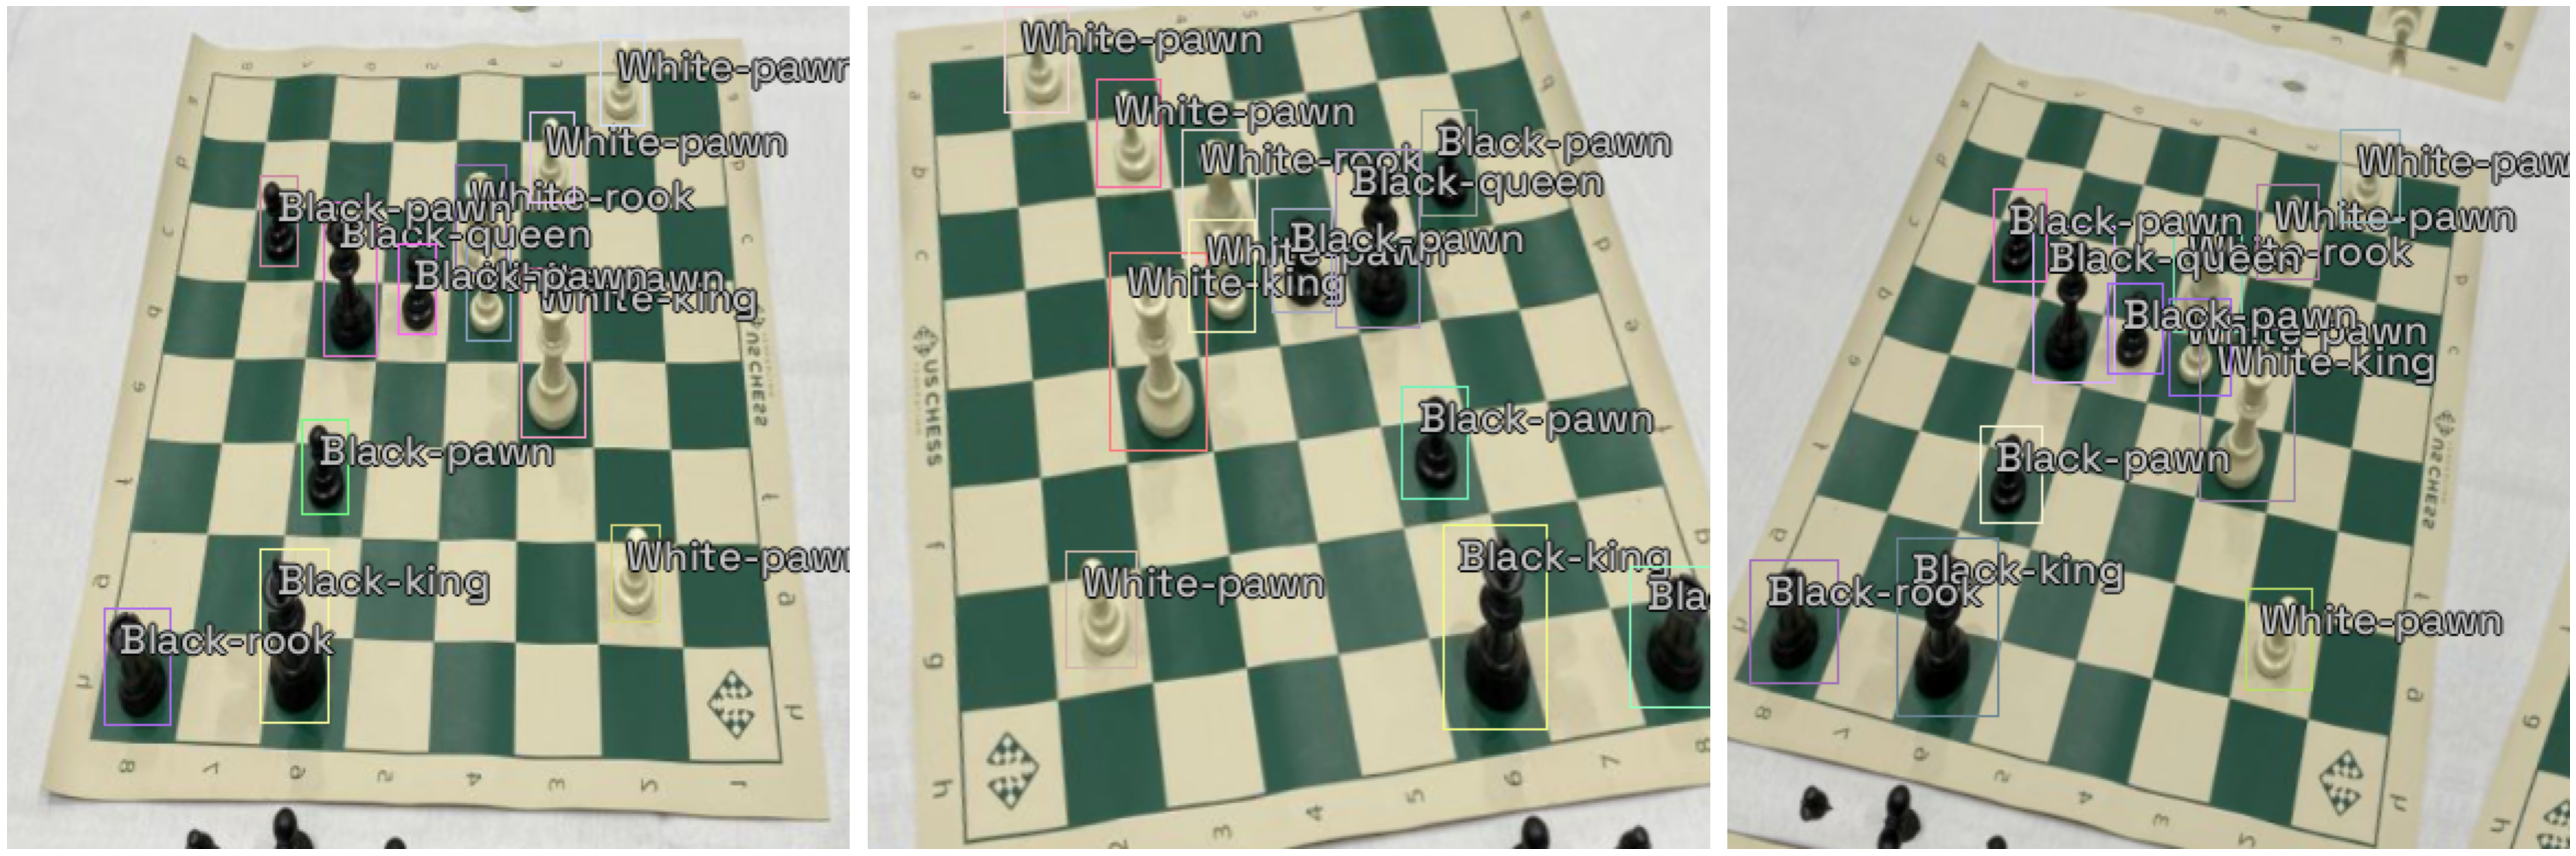

In [15]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

## Models

We've selected a few of the many options below. You can easily pick which libraries, models, and backbones you like to use.

In [16]:
# Just change the value of selection to try another model

selection = 0

extra_args = {}

if selection == 0:
    model_type = models.mmdet.vfnet
    backbone = model_type.backbones.resnet50_fpn_mstrain_2x

if selection == 1:
    model_type = models.mmdet.retinanet
    backbone = model_type.backbones.resnet50_fpn_1x

elif selection == 2:
    model_type = models.mmdet.faster_rcnn
    backbone = model_type.backbones.resnet50_fpn_1x
    # extra_args['cfg_options'] = {
    #   'model.bbox_head.loss_bbox.loss_weight': 2,
    #   'model.bbox_head.loss_cls.loss_weight': 0.8,
    #    }

elif selection == 3:
    # The Retinanet model is also implemented in the torchvision library
    model_type = models.torchvision.retinanet
    backbone = model_type.backbones.resnet50_fpn

elif selection == 4:
    model_type = models.ross.efficientdet
    backbone = model_type.backbones.tf_lite0
    # The efficientdet model requires an img_size parameter
    extra_args["img_size"] = image_size

elif selection == 5:
    model_type = models.ultralytics.yolov5
    backbone = model_type.backbones.small
    # The yolov5 model requires an img_size parameter
    extra_args["img_size"] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.mmdet.models.vfnet' from '/usr/local/lib/python3.7/dist-packages/icevision/models/mmdet/models/vfnet/__init__.py'>,
 {})

In [ ]:
# Instantiate the model
model = model_type.model(
    backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args
)

In [18]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

## Training

In [19]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training using fastai

In [20]:
learn = model_type.fastai.learner(
    dls=[train_dl, valid_dl], model=model, metrics=metrics
)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=3.0199516913853586e-05)

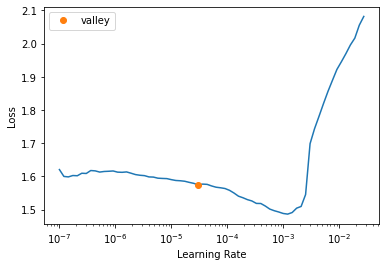

In [26]:
learn.lr_find()

In [27]:
learn.fine_tune(40, 1e-4, freeze_epochs=1)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


## Training using Pytorch Lightning

In [ ]:
# class LightModel(model_type.lightning.ModelAdapter):
#     def configure_optimizers(self):
#         return Adam(self.parameters(), lr=1e-4)

# light_model = LightModel(model, metrics=metrics)

In [ ]:
# trainer = pl.Trainer(max_epochs=20, gpus=1)
# trainer.fit(light_model, train_dl, valid_dl)

## Showing the results

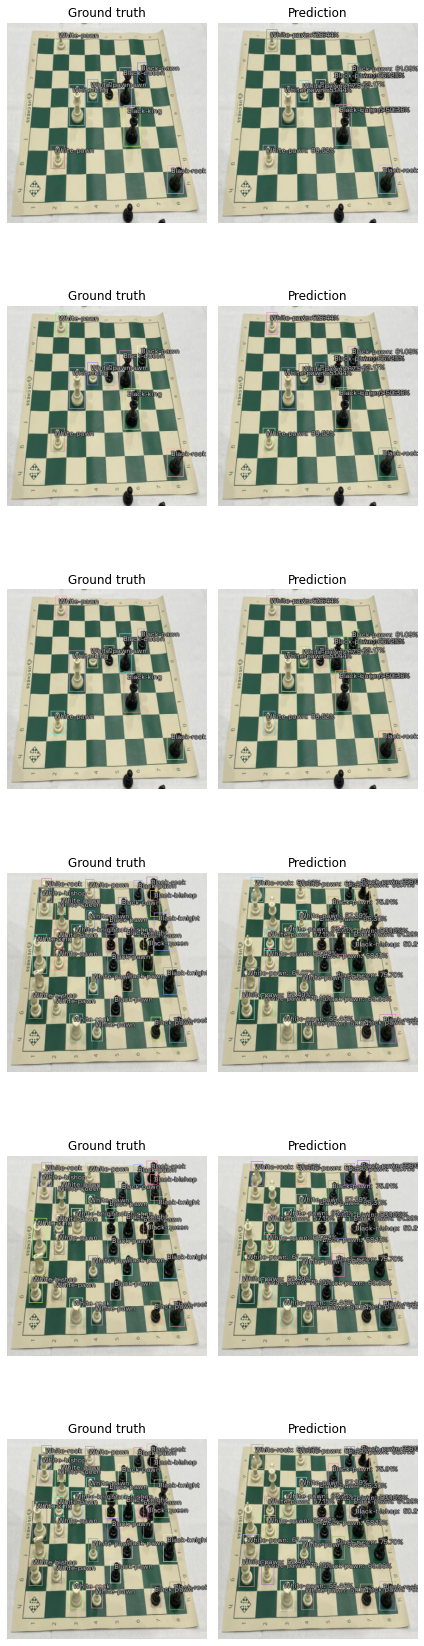

In [28]:
model_type.show_results(model, valid_ds, detection_threshold=0.5)

## Batch Inference (Prediction)

In [29]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/1 [00:00<?, ?it/s]

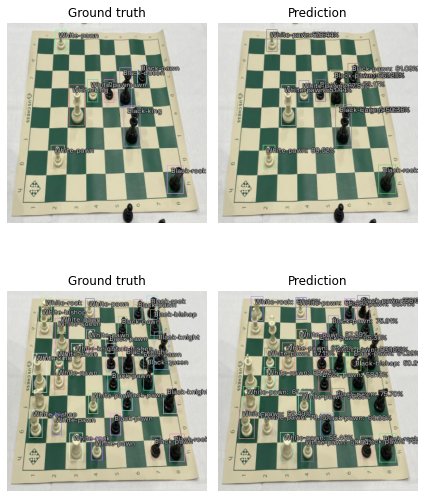

In [30]:
show_preds(preds=preds[:4])

## Conclusion
This notebook shows ho to create a custom parser to process data stored in format different than the popular COCO or VOV formats. 

The parsed data feed any IceVision models that could be trained by either Fastai or Pytorch-Lightning training loops.

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).